# 📡 QPSK: Single-Carrier vs OFDM (1 Subcarrier)

This notebook compares two digital modulation schemes:
- **Single-carrier QPSK with pulse shaping**
- **OFDM with a single active subcarrier**

Each modulation scheme is broken down step-by-step with signal plots and spectral analysis.

## 🔹 Single-Carrier QPSK with Pulse Shaping

### Step 1: Generate QPSK Symbols

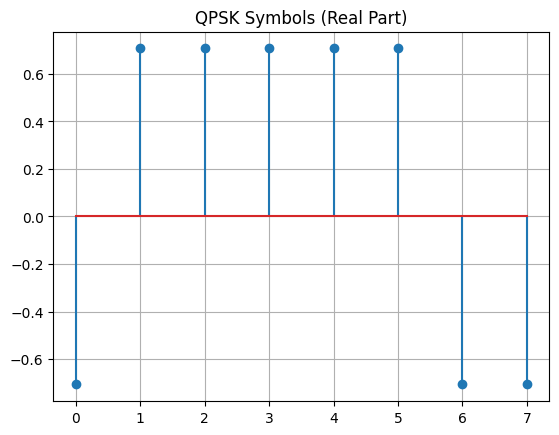

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.fft import ifft

# Parameters
num_symbols = 8
samples_per_symbol = 32
rolloff = 0.25
span = 6
fc = 2e3
fs = samples_per_symbol * 1e3

# Generate random QPSK symbols
np.random.seed(0)
bits = np.random.randint(0, 2, 2 * num_symbols)
symbols = (2 * bits[::2] - 1) + 1j * (2 * bits[1::2] - 1)
symbols /= np.sqrt(2)

plt.stem(np.real(symbols))
plt.title("QPSK Symbols (Real Part)")
plt.grid(True)
plt.show()


### Step 2: Pulse Shaping with Root Raised Cosine (RRC)

/tmp/ipykernel_35252/2079327554.py:4: RuntimeWarning: divide by zero encountered in divide
  h = np.sinc(t) * np.cos(np.pi * beta * t) / (1 - (2 * beta * t)**2)


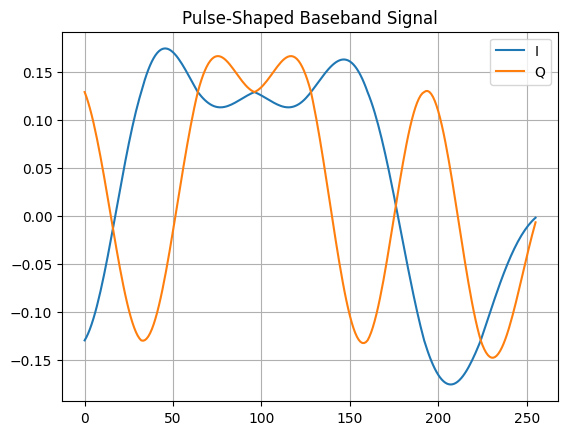

In [2]:

def rrc_filter(beta, sps, span):
    N = span * sps
    t = np.arange(-N / 2, N / 2 + 1) / sps
    h = np.sinc(t) * np.cos(np.pi * beta * t) / (1 - (2 * beta * t)**2)
    h[t == 0.5 / beta] = np.pi / 4 * np.sinc(1 / (2 * beta))
    h[t == -0.5 / beta] = np.pi / 4 * np.sinc(1 / (2 * beta))
    return h / np.sqrt(np.sum(h**2))

pulse = rrc_filter(rolloff, samples_per_symbol, span)
i_upsampled = np.zeros(num_symbols * samples_per_symbol)
q_upsampled = np.zeros_like(i_upsampled)
i_upsampled[::samples_per_symbol] = np.real(symbols)
q_upsampled[::samples_per_symbol] = np.imag(symbols)

i_shaped = convolve(i_upsampled, pulse, mode='same')
q_shaped = convolve(q_upsampled, pulse, mode='same')
baseband = i_shaped + 1j * q_shaped
t_total = np.arange(len(baseband)) / fs

plt.plot(np.real(baseband), label='I')
plt.plot(np.imag(baseband), label='Q')
plt.title("Pulse-Shaped Baseband Signal")
plt.legend(); plt.grid(True); plt.show()


### Step 3: RF Upconversion

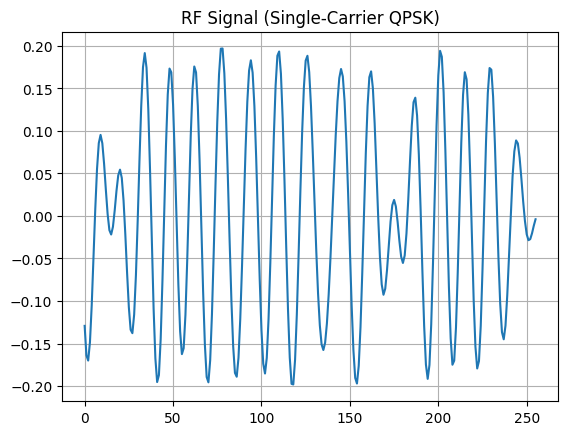

In [3]:

carrier = np.exp(1j * 2 * np.pi * fc * t_total)
rf_signal = np.real(baseband * carrier)

plt.plot(rf_signal)
plt.title("RF Signal (Single-Carrier QPSK)")
plt.grid(True)
plt.show()


### Step 4: Spectral Analysis

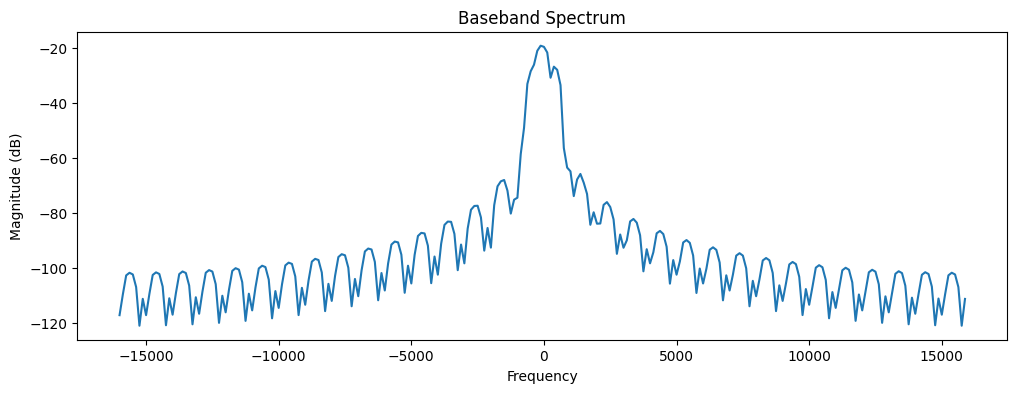

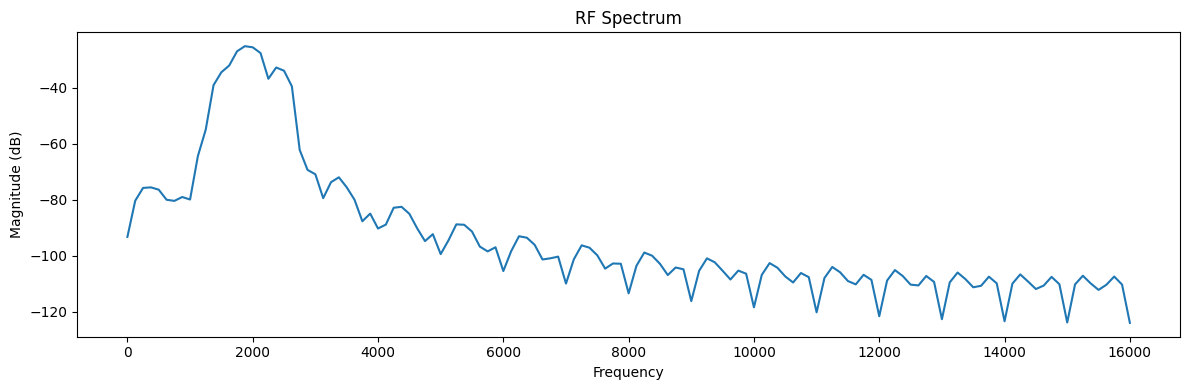

In [4]:

plt.figure(figsize=(12, 4))
plt.magnitude_spectrum(baseband, Fs=fs, scale='dB')
plt.title("Baseband Spectrum")

plt.figure(figsize=(12, 4))
plt.magnitude_spectrum(rf_signal, Fs=fs, scale='dB')
plt.title("RF Spectrum")
plt.tight_layout()
plt.show()


## 🔸 OFDM with One Subcarrier

### Step 1: IFFT to Create OFDM Symbol

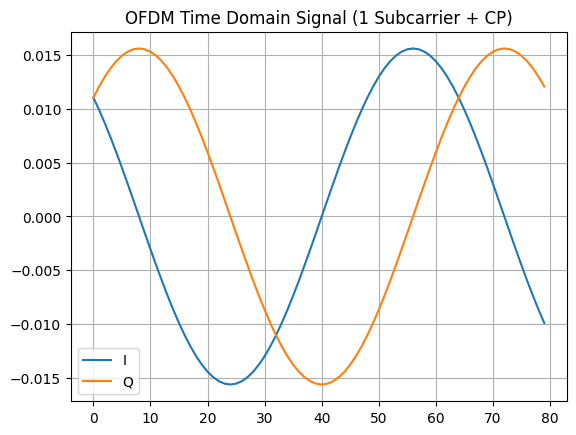

In [5]:

fft_size = 64
cp_length = 16
single_symbol = symbols[0]
ofdm_grid = np.zeros(fft_size, dtype=complex)
ofdm_grid[1] = single_symbol

ofdm_time = ifft(ofdm_grid)
ofdm_with_cp = np.concatenate([ofdm_time[-cp_length:], ofdm_time])

plt.plot(np.real(ofdm_with_cp), label='I')
plt.plot(np.imag(ofdm_with_cp), label='Q')
plt.title("OFDM Time Domain Signal (1 Subcarrier + CP)")
plt.legend(); plt.grid(True); plt.show()


### Step 2: RF Upconversion

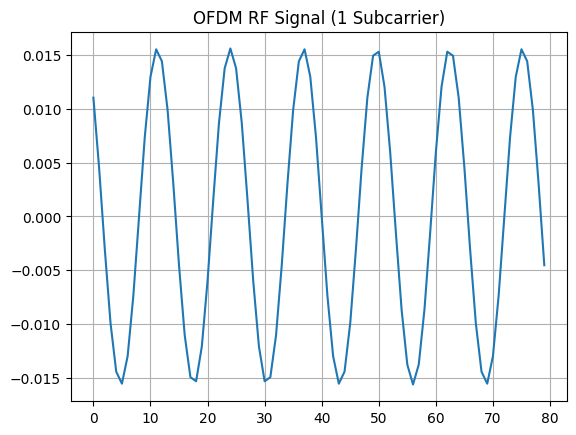

In [6]:

t_ofdm = np.arange(len(ofdm_with_cp)) / fs
carrier_ofdm = np.exp(1j * 2 * np.pi * fc * t_ofdm)
rf_ofdm = np.real(ofdm_with_cp * carrier_ofdm)

plt.plot(rf_ofdm)
plt.title("OFDM RF Signal (1 Subcarrier)")
plt.grid(True)
plt.show()


### Step 3: Spectrum

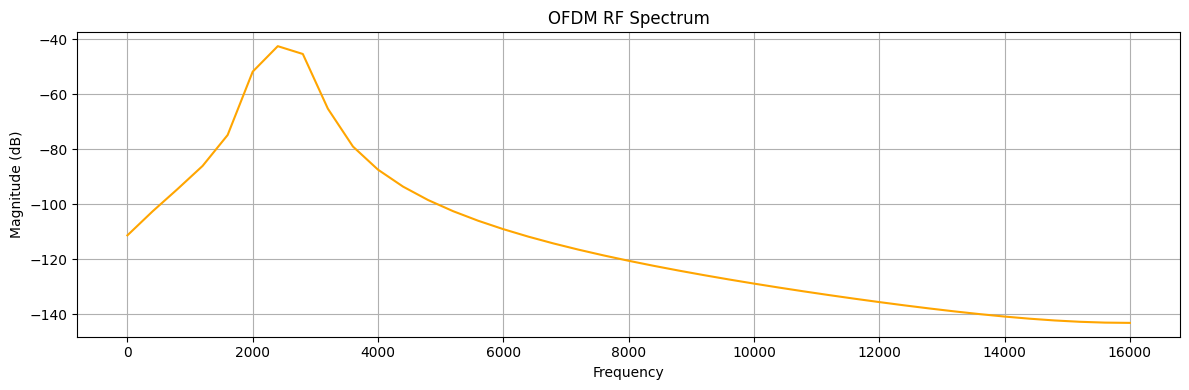

In [7]:

plt.figure(figsize=(12, 4))
plt.magnitude_spectrum(rf_ofdm, Fs=fs, scale='dB', color='orange')
plt.title("OFDM RF Spectrum")
plt.grid(True)
plt.tight_layout()
plt.show()
